In [ ]:
!git clone --recurse-submodules https://github.com/fastai/fastai
!pip install -e "fastai[dev]"

## kernel should be re-started after installing fastai-v2

### check fastai-v2 version 

In [1]:
import fastai
print(fastai.__version__)

2.0.2


# Tutorial from fastai doc

https://docs.fast.ai/tutorial.vision

## vision - beginner (dog or cat)

In [2]:
from fastai.vision.all import *

### grasp dataset & inspect a bit

In [3]:
path = untar_data(URLs.PETS)
print(path.ls())

(#2) [Path('/home/user/.fastai/data/oxford-iiit-pet/images'),Path('/home/user/.fastai/data/oxford-iiit-pet/annotations')]


In [4]:
# get_image_files
# - def get_image_files(path, recurse=True, folders=None):
#   - Get image files in `path` recursively, only in `folders`, if specified.
files = get_image_files(path/"images")
print(len(files))

7390


In [5]:
# just see filename examples for Cat and dog.
# - Cat - first capital letter 
# - dog - all lowercase
files[0],files[100]

(Path('/home/user/.fastai/data/oxford-iiit-pet/images/german_shorthaired_49.jpg'),
 Path('/home/user/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_156.jpg'))

### define a label function

all about how to label an item

In [6]:
# takes filename
# return how to label it
# - if filename is in uppercase => it's a Cat => it is labeled as True
# - if filename is in lowercase => it's a dog => it is labeled as False
def label_func(filename): 
    return filename[0].isupper()

### ImageDataLoaders with `from_name_func`

from forum about 'Why does ImageDataBunch.from_name_re() require a path argument?'
> After reading the source code, my current understanding is that path is a required property of the DataBunch parent class, since methods like DataBunch.save() will save directly to path. Additionally, the Learner class usually copies Learner.path from its data.path. This is used for things like Learner.save(), Learner.load(), and Learner.export(), which write to self.path/self.model_dir or just self.path.

In [7]:
# ImageDatLoader"s"
# - why plurals? => multiple DataLoaders (from PyTorch) are in it
#   - Training/Validation/Testing DataLoader

# from_name_func
# - path? => root path of dataset
# - fnames? => list of filenames (image filenames)
# - label_func? => how to label each data?
# - item_tfms? => item transforms
dls = ImageDataLoaders.from_name_func(path=path, 
                                      fnames=files, 
                                      label_func=label_func,
                                      item_tfms=Resize(224))

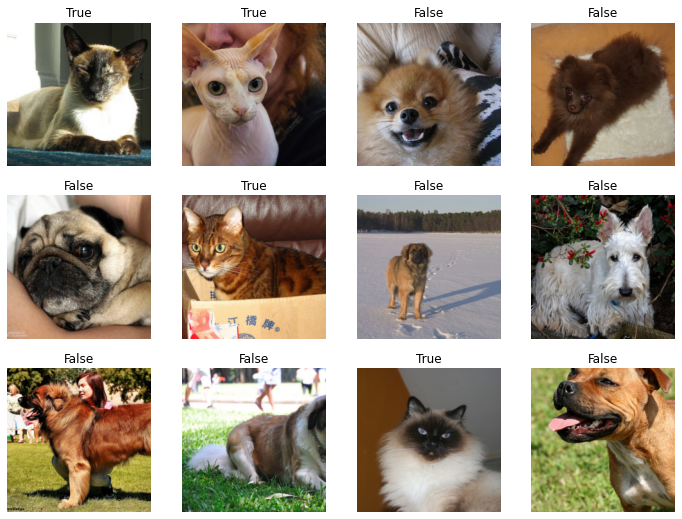

In [8]:
dls.show_batch(max_n=12)

### cnn_learner with fine_tune

In [9]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/user/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [10]:
# fine_tune is not a simple method
# - but all the details are hidden, but also you can adjust the details
""" 
  - Learner.fine_tune(epochs, 
                      base_lr=0.002, 
                      freeze_epochs=1, 
                      lr_mult=100, 
                      pct_start=0.3, 
                      div=5.0, 
                      lr_max=None, 
                      div_final=100000.0, 
                      wd=None, 
                      moms=None, 
                      cbs=None, 
                      reset_opt=False)
"""

learn.fine_tune(epochs=1)

### predict

In [11]:
# results
# - first item? => "predicted label"
# - second item? => index or predicted result tensor
# - third item? => actual output tensor

learn.predict(files[0])

('False', tensor(0), tensor([1.0000e+00, 8.6281e-07]))

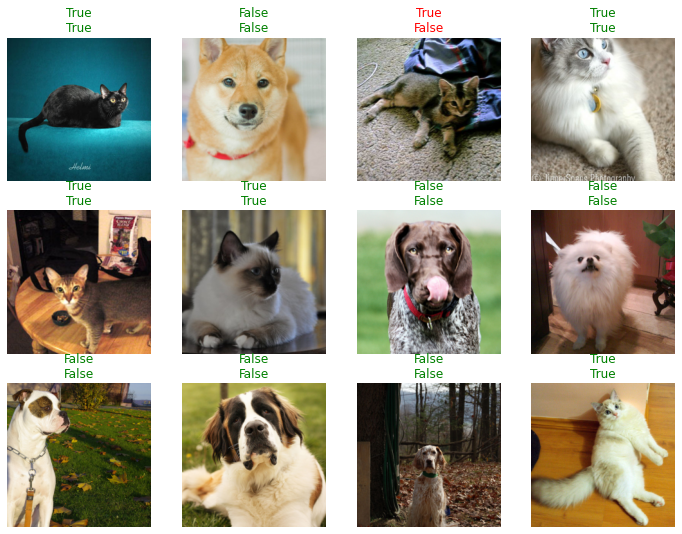

In [12]:
# just show some randomly chosen data from validation set
# - but we can actually choose the target dataset
#   - with ds_idx argument
#     - ds_idx=1 is default (validation), 0 is for training set
learn.show_results(max_n=12)

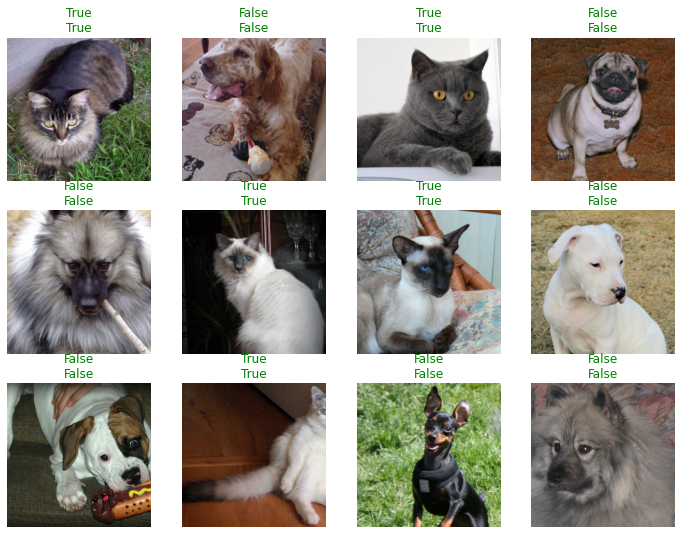

In [13]:
# on training dataset
learn.show_results(ds_idx=0, max_n=12)

### fastai Interpreter

In [14]:
interp = Interpretation.from_learner(learn)

In [16]:
interp.top_losses(k=20)

torch.return_types.topk(
values=tensor([5.8659, 4.7590, 4.5521, 1.8459, 1.6657, 1.6071, 1.6005, 1.4597, 1.4470,
        1.4424, 1.1674, 1.0468, 0.9538, 0.5710, 0.4560, 0.4243, 0.4099, 0.3973,
        0.3943, 0.3182]),
indices=tensor([ 873, 1236,  961,  947, 1287,  912,  298, 1154,  662,  307,  361, 1156,
        1041,  227,  878, 1308,   94, 1433,  859,  187]))

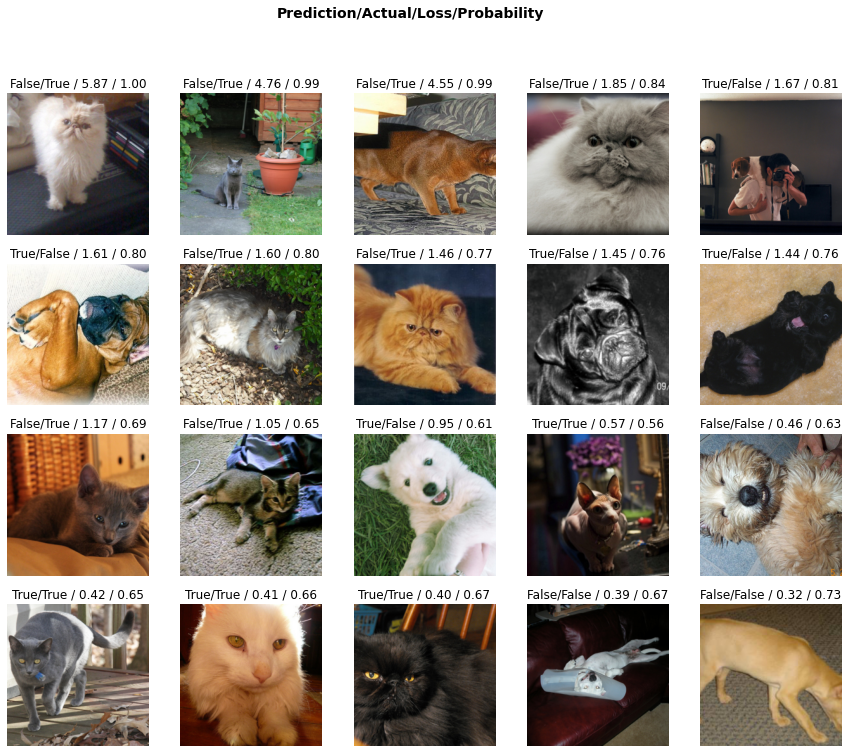

In [17]:
interp.plot_top_losses(k=20)

In [18]:
classification_interp = ClassificationInterpretation.from_learner(learn)

In [20]:
classification_interp.print_classification_report()

              precision    recall  f1-score   support

       False       0.99      1.00      0.99      1020
        True       0.99      0.98      0.99       458

    accuracy                           0.99      1478
   macro avg       0.99      0.99      0.99      1478
weighted avg       0.99      0.99      0.99      1478



In [22]:
classification_interp.most_confused()

[(True, False, 8), (False, True, 5)]

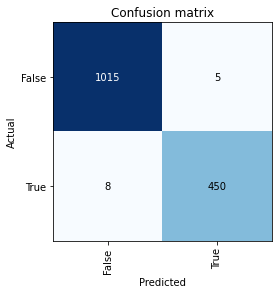

In [23]:
classification_interp.plot_confusion_matrix()

### Using W&B (Weights & Bias)

In [ ]:
# install wandb
!pip install wandb

In [ ]:
# login
import wandb
wandb.login()

In [ ]:
# initialize wandb project
# - it will create the project with endpoint
wandb.init(project='my_project')

In [ ]:
# import wandb callback in fastai
from fastai.callback.wandb import *

# leave logs for everything
learn = cnn_learner(dls, resnet34, metrics=error_rate, cbs=WandbCallback())
learn.fine_tune(epochs=4)
# leave logs for training process only
# - learn.fine_tune(epochs=4, cbs=WandbCallback())

## vision - beginner (dog breed)

In [24]:
from fastai.vision.all import *

path = untar_data(URLs.PETS)
files = get_image_files(path/"images")

In [25]:
pat = r'^(.*)_\d+.jpg'

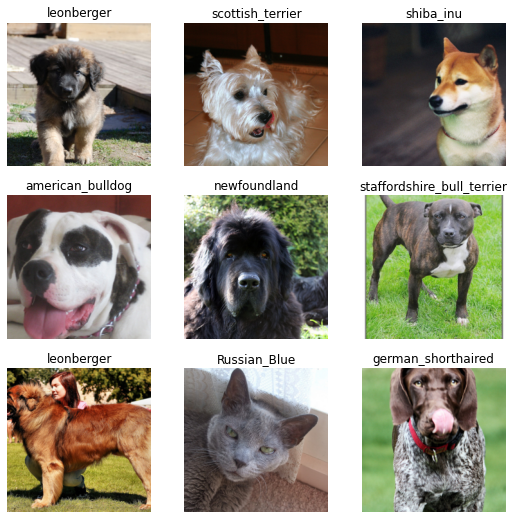

In [26]:
dls = ImageDataLoaders.from_name_re(path=path,
                                    fnames=files,
                                    pat=pat,
                                    item_tfms=Resize(224))
dls.show_batch()

In [27]:
dls = ImageDataLoaders.from_name_re(path=path, 
                                    fnames=files, 
                                    pat=pat, 
                                    item_tfms=Resize(460),
                                    batch_tfms=aug_transforms(size=224))

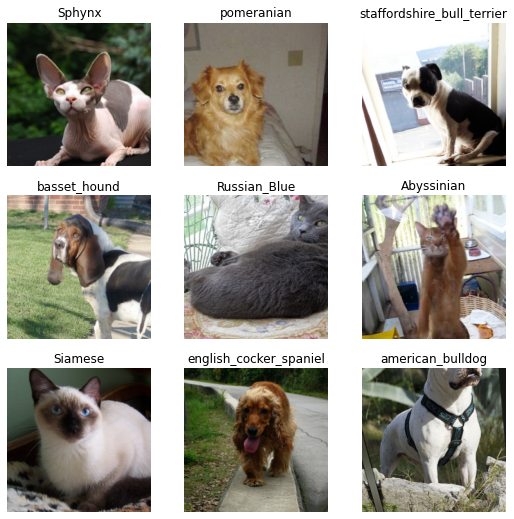

In [28]:
dls.show_batch()

In [29]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.005248074419796467)

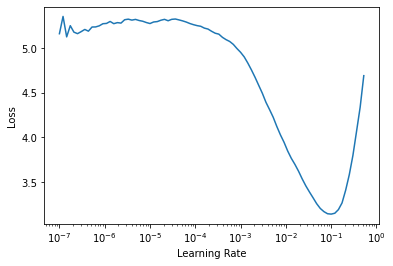

In [30]:
learn.lr_find()

In [31]:
learn.fine_tune(4, 5e-3)

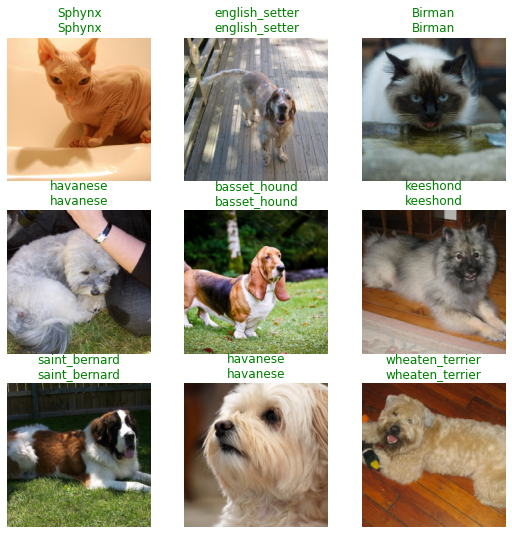

In [32]:
learn.show_results()

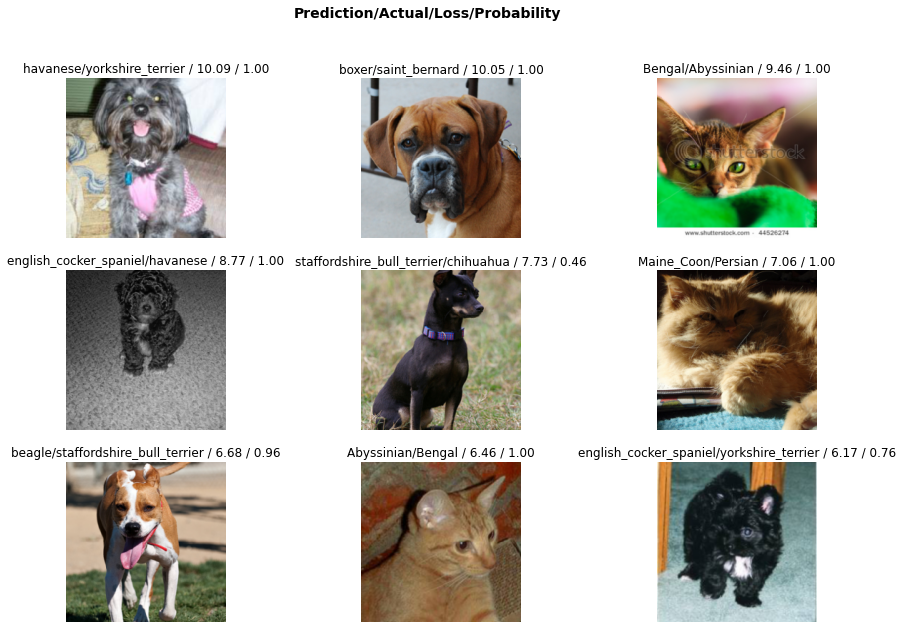

In [33]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))

In [34]:
classification_interp = ClassificationInterpretation.from_learner(learn)
classification_interp.print_classification_report()

                            precision    recall  f1-score   support

                Abyssinian       0.93      0.91      0.92        45
                    Bengal       0.85      0.85      0.85        39
                    Birman       0.90      0.97      0.94        38
                    Bombay       0.97      1.00      0.98        32
         British_Shorthair       0.91      0.98      0.94        41
              Egyptian_Mau       0.88      0.90      0.89        42
                Maine_Coon       0.92      0.92      0.92        52
                   Persian       1.00      0.89      0.94        36
                   Ragdoll       0.86      0.88      0.87        43
              Russian_Blue       0.97      0.90      0.94        40
                   Siamese       0.93      0.93      0.93        40
                    Sphynx       0.98      0.93      0.96        46
          american_bulldog       0.84      0.79      0.81        33
 american_pit_bull_terrier       0.73      0.75

In [36]:
classification_interp.most_confused(min_val=3)

[('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5),
 ('Bengal', 'Egyptian_Mau', 4),
 ('Egyptian_Mau', 'Bengal', 4),
 ('Maine_Coon', 'Ragdoll', 4),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('Russian_Blue', 'British_Shorthair', 3),
 ('Sphynx', 'chihuahua', 3),
 ('american_bulldog', 'american_pit_bull_terrier', 3),
 ('american_pit_bull_terrier', 'miniature_pinscher', 3),
 ('staffordshire_bull_terrier', 'american_bulldog', 3),
 ('yorkshire_terrier', 'havanese', 3)]

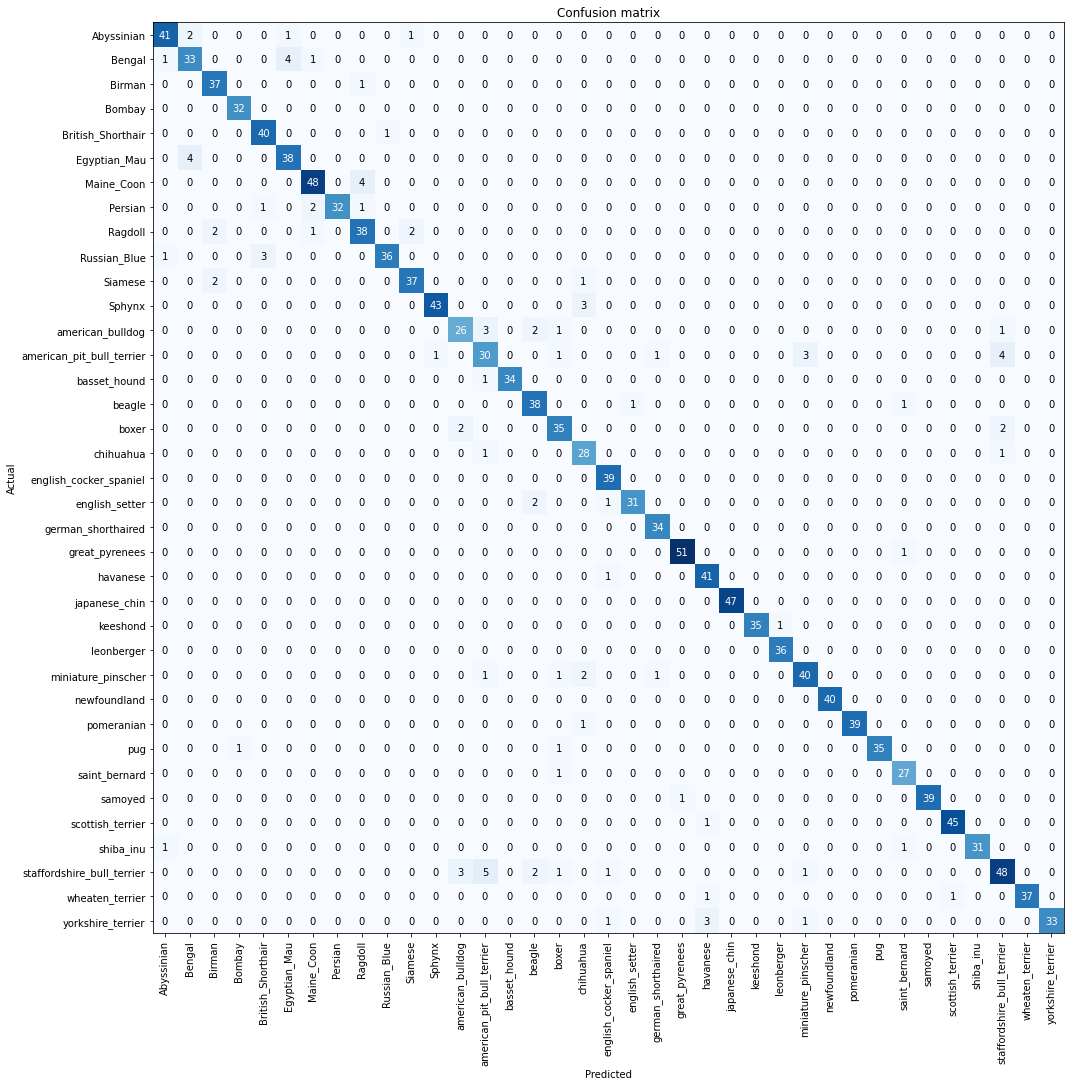

In [40]:
classification_interp.plot_confusion_matrix(figsize=(20,15))